# Download AEF Embeddings

In [1]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from mangroves.embeddings import Embeddings
from mangroves.collection import Collection

In [2]:
REGION_DIAMETER_P = 250
SPATIAL_RESOLUTION_M = 10

In [3]:
# project = os.getenv('GEE_PROJECT_KEY')
with open('/home/nus/workspace/tutorial/GEE/gee_project_key.txt', "r") as f:
    project = f.readline().strip()

collection = Collection(project=project)

2025-11-11 18:51:53,099 - INFO - Google Earth Engine initialized successfully with service account


In [6]:
input_samples = pd.read_csv('../share/data/samples_mangrove.csv')
latitude_deg = input_samples['latitude'].tolist()[0]
longitude_deg = input_samples['longitude'].tolist()[0]
year = input_samples['year'].tolist()[0]

file_configs = [
    {
        'description': 'test',
        'file': os.path.join(os.getcwd(), '../share/data/samples_mangrove.csv'),
        'strategy': 'later',
        'output_dir': os.path.join('/home/nus/Downloads/gee_outputs/'),
        'prefix': 'test_'
    },
]

latitude_deg, longitude_deg, year

(3.8046593211, 98.6429308016, 2020)

In [7]:
embeddings = Embeddings()
embeddings.from_collection(
    latitude_deg, 
    longitude_deg, 
    year, 
    REGION_DIAMETER_P, 
    SPATIAL_RESOLUTION_M, 
    collection
)

2025-11-11 18:52:40,480 - INFO - Filtered images for 2020: 1
2025-11-11 18:52:53,586 - INFO - Successfully extracted 64 bands
2025-11-11 18:52:53,600 - INFO - Successfully created patch with shape: (64, 249, 251)


In [ ]:
#def process_single_file(file_config, max_features=None, start_idx=0):
# setting max_features=3, and only process the first 3 features
def process_single_file(file_config, max_features=3, start_idx=0):
    """Process a single file for embedding download"""
    logger.info(f'   Processing: {file_config["description"]}')
    logger.info(f'   File: {file_config["file"]}')
    logger.info(f'   Strategy: {file_config["strategy"]}')
    logger.info(f'   Output: {file_config["output_dir"]}')
    logger.info(f'   Prefix: {file_config["prefix"]}')
    logger.info(f'   Max features: {max_features}')
    
    # Read CSV file
    try:
        df = pd.read_csv(file_config['file'])
        logger.info(f' Records: {len(df):,}')
    except Exception as e:
        logger.info(f' Failed to read file: {e}')
        return {'successful': 0, 'failed': 0, 'skipped': 0}
    
    # Prepare features for download
    features = []
    for idx, row in df.iterrows():
        logger.info(f' Processing row {idx}')
        if max_features and len(features) >= max_features:
            logger.info(f' Reached max features limit: {max_features}')
            break
        
        if idx < start_idx:
            logger.info(f' Skipping row {idx} before start index {start_idx}')
            continue
        
        # Get coordinates
        lat = row.get('latitude')
        lon = row.get('longitude')
        
        if pd.isna(lat) or pd.isna(lon):
            logger.info(f' Skipping row {idx} due to missing coordinates')
            continue
        
        # Get date field based on file type
        if 'Peak_Data' in file_config['file']:
            date_field = 'peak_date'
        else:
            date_field = 'year'
        
        peak_date = row.get(date_field)
        download_year = get_download_year(peak_date, file_config['strategy'])
        
        if download_year is None:
            logger.info(f' Skipping row {idx} due to invalid download year')
            continue
        
        # Get feature ID
        if 'ID' in row:
            feature_id = row['ID']
        else:
            feature_id = idx
        
        # Create filename
        filename = f'{file_config["prefix"]}{feature_id}.npz'
        output_path = os.path.join(file_config['output_dir'], filename)
        
        # Skip if exists
        if os.path.exists(output_path):
            logger.info(f' Skipping existing file: {output_path}')
            continue
        
        features.append({
            'feature_id': feature_id,
            'latitude': lat,
            'longitude': lon,
            'download_year': download_year,
            'filename': filename,
            'output_path': output_path
        })
    
    logger.info(f' Valid features for download: {len(features):,}')
    
    if not features:
        logger.info(' No valid features to download')
        return {'successful': 0, 'failed': 0, 'skipped': 0}
    
    # Download embeddings with improved error handling
    stats = {'successful': 0, 'failed': 0, 'skipped': 0}
    
    # Process features sequentially to avoid GEE quota issues
    for i, feature in enumerate(features):
        logger.info(f'Processing feature {i+1}/{len(features)}: {feature["filename"]}')
        
        try:
            # Extract patch with retry mechanism
            patch = extract_patch(
                feature['latitude'],
                feature['longitude'],
                feature['download_year'],
                max_retries=3
            )
            
            if patch is not None:
                # Save patch
                if save_patch_as_numpy(patch, feature['output_path'], feature['feature_id'], 
                                   feature['latitude'], feature['longitude'], feature['download_year']):
                    stats['successful'] += 1
                    logger.info(f' Successfully saved: {feature["filename"]}')
                else:
                    stats['failed'] += 1
                    logger.error(f' Failed to save: {feature["filename"]}')
            else:
                stats['failed'] += 1
                logger.error(f' Failed to extract patch: {feature["filename"]}')
                
        except Exception as e:
            logger.error(f' Error processing {feature["filename"]}: {e}')
            stats['failed'] += 1
        
        # Rate limiting between features to avoid quota issues
        time.sleep(1)
    
    return stats

In [89]:
# Start downloading embeddings
#print('Starting Multi-File AlphaEarth Embedding Download')
#print('=' * 50)
# Start downloading embeddings (only first 3 files, 3 features each)
print('Starting Multi-File AlphaEarth Embedding Download (Limited to 3 files, 3 features each)')
print('=' * 70)

total_stats = {'successful': 0, 'failed': 0, 'skipped': 0}

for i, file_config in enumerate(file_configs):
    print(f'\n Processing file {i}/{len(file_configs)}: {file_config["description"]}')
    
    # Process file
    #stats = process_single_file(file_config)
    # Process file (max 3 features per file)
    stats = process_single_file(file_config, max_features=3)    
    # Update totals
    for key in total_stats:
        total_stats[key] += stats[key]
    
    print(f' Results: {stats["successful"]} successful, {stats["failed"]} failed')

print(f'\n All embedding downloads completed!')
print(f' Final Summary:')
print(f'   Total successful: {total_stats["successful"]:,}')
print(f'   Total failed: {total_stats["failed"]:,}')
print(f'   Total skipped (existing): {total_stats["skipped"]:,}')

# Calculate success rate with zero division protection
total_attempted = total_stats["successful"] + total_stats["failed"]
if total_attempted > 0:
    success_rate = total_stats["successful"] / total_attempted * 100
    print(f'   Overall success rate: {success_rate:.1f}%')
else:
    print(f'   Overall success rate: N/A (no downloads attempted)')

2025-11-11 14:36:04,332 - INFO -    Processing: test
2025-11-11 14:36:04,332 - INFO -    File: /home/nus/workspace/mangroves/data/csv/test_output.csv
2025-11-11 14:36:04,332 - INFO -    Strategy: later
2025-11-11 14:36:04,333 - INFO -    Output: /home/nus/workspace/mangroves/data/results/embeddings
2025-11-11 14:36:04,333 - INFO -    Prefix: gage_
2025-11-11 14:36:04,333 - INFO -    Max features: 3
2025-11-11 14:36:04,335 - INFO -  Records: 1
2025-11-11 14:36:04,336 - INFO -  Processing row 0
2025-11-11 14:36:04,336 - INFO - Parsed peak year: 2020 from date: 2020
2025-11-11 14:36:04,336 - INFO - Later strategy selected, download year: 2021
2025-11-11 14:36:04,337 - INFO -  Valid features for download: 1
2025-11-11 14:36:04,337 - INFO - Processing feature 1/1: gage_0.npz
2025-11-11 14:36:04,337 - INFO - Attempt 1/3 for (3.8047, 98.6429) in 2021


Starting Multi-File AlphaEarth Embedding Download (Limited to 3 files, 3 features each)

 Processing file 0/1: test


2025-11-11 14:36:04,694 - INFO - Found 1 images for year 2021
2025-11-11 14:36:19,155 - INFO - Successfully extracted 64 bands
2025-11-11 14:36:19,168 - INFO - Successfully created patch with shape: (64, 249, 251)
2025-11-11 14:36:20,057 - INFO -  Successfully saved: gage_0.npz


 Results: 1 successful, 0 failed

 All embedding downloads completed!
 Final Summary:
   Total successful: 1
   Total failed: 0
   Total skipped (existing): 0
   Overall success rate: 100.0%


### Plot data

In [95]:
data_path = os.path.join(base_dir, 'data/results', 'embeddings', 'gage_0.npz')
loaded_data = np.load(data_path)
loaded_data.files, loaded_data['image_data'].shape

(['image_data',
  'feature_id',
  'centroid_lon',
  'centroid_lat',
  'year',
  'num_images',
  'band_names',
  'flipud_applied'],
 (64, 249, 251))

2025-11-11 14:40:00,918 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11909265667051133..0.28444444444444444].


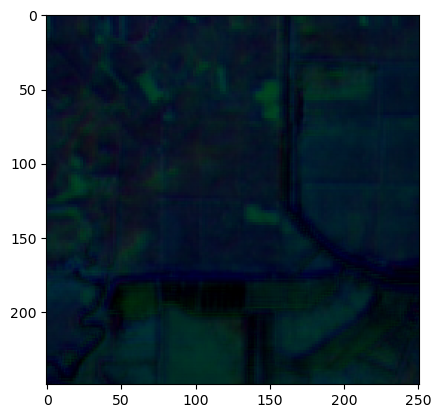

In [96]:
plt.imshow(loaded_data['image_data'][0:3].transpose(1, 2, 0), cmap='viridis')